# Library

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna


from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Data Loading

In [2]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

In [3]:
train

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience,blueWins
0,0,0,5,8,6,0,0,14536,17256,0
1,1,1,10,1,5,0,0,14536,17863,0
2,2,0,3,10,2,0,0,17409,17256,0
3,3,1,7,10,8,0,0,19558,18201,0
4,4,0,4,9,4,0,0,17409,17256,0
...,...,...,...,...,...,...,...,...,...,...
7995,9993,1,9,6,14,0,0,18513,18201,1
7996,9994,0,3,10,4,0,0,17381,19797,0
7997,9995,1,9,3,9,2,1,18274,18491,1
7998,9997,0,5,10,6,1,1,18274,18491,1


In [4]:
test

,gameId,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueTotalGold,blueTotalExperience
0,9,0,7,6,6,0,0,16961,18201
1,15,0,6,6,6,2,1,18513,18021
2,18,1,6,4,3,0,0,13475,17256
3,23,0,5,4,7,0,0,17409,17256
4,31,0,10,8,9,0,0,18117,18472
...,...,...,...,...,...,...,...,...,...
1995,9971,0,6,3,7,0,0,17409,17256
1996,9980,0,4,4,4,0,0,17409,17256
1997,9983,1,6,3,3,1,1,18513,18201
1998,9996,1,10,9,9,1,1,18513,18201


# Feature

- 各特長量の説明

| ヘッダ名称            | データ型 | 説明                                                       |
|---------------------|-------|----------------------------------------------------------|
| gameId             | int   | ゲームID                                                    |
| blueFirstBlood      | int   | ゲームの最初のキル。青チームが最初のキルを行った場合は1、それ以外の場合は0 |
| blueKills           | int   | 青チームによって殺された敵の数                                     |
| blueDeaths          | int   | 青チームの死亡者数                                            |
| blueAssists         | int   | 青チームのキルアシストの数                                      |
| blueEliteMonsters   | int   | 青チームによって殺されたエリートモンスターの数（ドラゴンとヘラルド）       |
| blueDragons         | int   | 青チームによって殺されたドラゴンの数                               |
| blueTotalGold       | int   | 青チームの得たゴールド合計                                       |
| blueTotalExperience | int   | 青チームの得た経験値合計                                       |
| blueWins            | int   | 目的変数（青チームが勝った場合は1、それ以外の場合は0。）                |


gameIdとgoldは相関無さそう

# Feature Engineering

- Add new feature

In [5]:
def create_features(df):
    """
    与えられたデータフレームに対して特徴量エンジニアリングを行う関数。

    Args:
    df (DataFrame): 特徴量エンジニアリングを行うデータフレーム

    Returns:
    DataFrame: 新しい特徴量が追加されたデータフレーム
    """
    # キルとデスの比率
    df['killDeathRatio'] = df['blueKills'] / (df['blueDeaths'] + 1)  # ゼロ除算を防ぐために+1

    # アシストの割合
    df['assistRate'] = df['blueAssists'] / (df['blueKills'] + 1)

    # ヘラルドの討伐数
    df['blueHerald'] = df['blueEliteMonsters'] - df['blueDragons']
    # blueHerald列の負の値を0で置き換え
    df['blueHerald'] = df['blueHerald'].clip(lower=0)

    # エリートモンスターとドラゴンの比率
    df['eliteMonsterDragonRatio'] = df['blueEliteMonsters'] / (df['blueDragons'] + 1)
    # エリートモンスターとヘラルドの比率
    df['eliteMonsterHeraldRatio'] = df['blueEliteMonsters'] / (df['blueHerald'] + 1)

    # ゴールドと経験値の対数変換
    df['logTotalGold'] = np.log1p(df['blueTotalGold'])
    df['logTotalExperience'] = np.log1p(df['blueTotalExperience'])

    # ゴールドと経験値の相互作用
    df['goldXexperience'] = df['blueTotalGold'] * df['blueTotalExperience']

    # 初期キルの影響
    df['firstBloodKillRatio'] = df['blueFirstBlood'] * df['blueKills']
    
    # キル、デス、アシストの合計
    df['totalCombatPoints'] = df['blueKills'] + df['blueDeaths'] + df['blueAssists']

    # キル・デス・アシスト比率
    total_combat_actions = df['blueKills'] + df['blueDeaths'] + df['blueAssists']
    df['killRatio'] = df['blueKills'] / total_combat_actions
    df['deathRatio'] = df['blueDeaths'] / total_combat_actions
    df['assistRatio'] = df['blueAssists'] / total_combat_actions

    # 効率的なリソース利用
    df['goldPerKill'] = df['blueTotalGold'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1
    df['experiencePerKill'] = df['blueTotalExperience'] / (df['blueKills'] + 1)  # ゼロ除算を防ぐために+1

    # エリートモンスターの討伐効率
    df['eliteMonstersPerGold'] = df['blueEliteMonsters'] / df['blueTotalGold']
    df['eliteMonstersPerExperience'] = df['blueEliteMonsters'] / df['blueTotalExperience']

    # チームの総合力
    df['teamStrength'] = df['blueKills'] + df['blueAssists'] + df['blueEliteMonsters']

    return df

- Apply data

In [6]:
train = create_features(train)
test = create_features(test)

# model

- LightGBM

[I 2024-01-18 13:18:25,563] A new study created in memory with name: no-name-b9fbd110-7313-4253-8ca1-35485f3fa101


Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:25,979] Trial 0 finished with value: 0.798125 and parameters: {'lambda_l1': 2.808220081586791e-06, 'lambda_l2': 8.625593639196039, 'num_leaves': 111, 'feature_fraction': 0.4778415189518611, 'bagging_fraction': 0.8600692180934641, 'bagging_freq': 2, 'min_child_samples': 16}. Best is trial 0 with value: 0.798125.
[I 2024-01-18 13:18:26,033] Trial 1 finished with value: 0.80625 and parameters: {'lambda_l1': 1.934493909597274e-05, 'lambda_l2': 0.05738701541470835, 'num_leaves': 11, 'feature_fraction': 0.41955976075320534, 'bagging_fraction': 0.8857679503976366, 'bagging_freq': 7, 'min_child_samples': 87}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,107] Trial 2 finished with value: 0.79625 and parameters: {'lambda_l1': 0.0009666751045126059, 'lambda_l2': 0.00017597907958288167, 'num_leaves': 139, 'feature_fraction': 0.4658310265404912, 'bagging_fraction': 0.9866639026372738, 'bagging_freq': 4, 'min_child_samples': 6}. Best is trial 1 with value: 0.80625.

Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:26,206] Trial 3 finished with value: 0.788125 and parameters: {'lambda_l1': 0.006992833381359928, 'lambda_l2': 0.002059079649082991, 'num_leaves': 227, 'feature_fraction': 0.981458118595975, 'bagging_fraction': 0.4646191643555566, 'bagging_freq': 2, 'min_child_samples': 7}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,249] Trial 4 finished with value: 0.801875 and parameters: {'lambda_l1': 2.614206001959768e-05, 'lambda_l2': 4.352535863396801e-05, 'num_leaves': 70, 'feature_fraction': 0.8246566041617002, 'bagging_fraction': 0.5717183965605486, 'bagging_freq': 2, 'min_child_samples': 59}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,329] Trial 5 finished with value: 0.795625 and parameters: {'lambda_l1': 5.2350514804075646e-08, 'lambda_l2': 1.3484424954314803e-08, 'num_leaves': 219, 'feature_fraction': 0.5269641943118704, 'bagging_fraction': 0.9753643545762158, 'bagging_freq': 5, 'min_child_samples': 16}. Best is trial 1 with value: 0.80

Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.211875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.198125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.204375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.205625


[I 2024-01-18 13:18:26,463] Trial 7 finished with value: 0.80625 and parameters: {'lambda_l1': 2.615880429407813e-08, 'lambda_l2': 0.0007075376391187529, 'num_leaves': 41, 'feature_fraction': 0.5649191336680266, 'bagging_fraction': 0.943817263633182, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,512] Trial 8 finished with value: 0.79375 and parameters: {'lambda_l1': 3.566056935937877e-08, 'lambda_l2': 0.007909220914934607, 'num_leaves': 137, 'feature_fraction': 0.5235632724214142, 'bagging_fraction': 0.4398131984141703, 'bagging_freq': 6, 'min_child_samples': 53}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,562] Trial 9 finished with value: 0.8025 and parameters: {'lambda_l1': 7.261575647993539e-08, 'lambda_l2': 0.8912630271751631, 'num_leaves': 117, 'feature_fraction': 0.5066944522444449, 'bagging_fraction': 0.721185357927095, 'bagging_freq': 2, 'min_child_samples': 73}. Best is trial 1 with value: 0.80625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[33]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.20625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.1975


[I 2024-01-18 13:18:26,652] Trial 10 finished with value: 0.79625 and parameters: {'lambda_l1': 8.47649969565004, 'lambda_l2': 0.07009831051725117, 'num_leaves': 9, 'feature_fraction': 0.6486587515955078, 'bagging_fraction': 0.8286684724031887, 'bagging_freq': 7, 'min_child_samples': 98}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,711] Trial 11 finished with value: 0.771875 and parameters: {'lambda_l1': 1.9730598581177017e-06, 'lambda_l2': 3.746502869059566e-05, 'num_leaves': 6, 'feature_fraction': 0.4056660075534821, 'bagging_fraction': 0.889699761603747, 'bagging_freq': 4, 'min_child_samples': 76}. Best is trial 1 with value: 0.80625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.228125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:26,871] Trial 12 finished with value: 0.798125 and parameters: {'lambda_l1': 1.5037951784367256e-08, 'lambda_l2': 0.01798742810172159, 'num_leaves': 47, 'feature_fraction': 0.6124668207426848, 'bagging_fraction': 0.9142948731479241, 'bagging_freq': 3, 'min_child_samples': 75}. Best is trial 1 with value: 0.80625.
[I 2024-01-18 13:18:26,981] Trial 13 finished with value: 0.805 and parameters: {'lambda_l1': 1.3872333104500806e-06, 'lambda_l2': 0.0011671147494073848, 'num_leaves': 42, 'feature_fraction': 0.5875506265969099, 'bagging_fraction': 0.7889412145534671, 'bagging_freq': 5, 'min_child_samples': 36}. Best is trial 1 with value: 0.80625.


Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.201875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:27,078] Trial 14 finished with value: 0.806875 and parameters: {'lambda_l1': 4.658857553941203e-05, 'lambda_l2': 5.626742266529006e-06, 'num_leaves': 44, 'feature_fraction': 0.4040029069552221, 'bagging_fraction': 0.9982689207112813, 'bagging_freq': 1, 'min_child_samples': 100}. Best is trial 14 with value: 0.806875.
[I 2024-01-18 13:18:27,166] Trial 15 finished with value: 0.8 and parameters: {'lambda_l1': 6.043763696065304e-05, 'lambda_l2': 9.691289825713795e-07, 'num_leaves': 181, 'feature_fraction': 0.40105699643615117, 'bagging_fraction': 0.8969793304401508, 'bagging_freq': 1, 'min_child_samples': 94}. Best is trial 14 with value: 0.806875.
[I 2024-01-18 13:18:27,215] Trial 16 finished with value: 0.755625 and parameters: {'lambda_l1': 0.00013065759620906625, 'lambda_l2': 3.913981216870353e-06, 'num_leaves': 2, 'feature_fraction': 0.6981245990914016, 'bagging_fraction': 0.9965633069627318, 'bagging_freq': 6, 'min_child_samples': 85}. Best is trial 14 with value

Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.244375


[I 2024-01-18 13:18:27,327] Trial 17 finished with value: 0.8025 and parameters: {'lambda_l1': 0.013539230495028148, 'lambda_l2': 0.1179198921142533, 'num_leaves': 74, 'feature_fraction': 0.40328870475408224, 'bagging_fraction': 0.8146681818712949, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 14 with value: 0.806875.
[I 2024-01-18 13:18:27,417] Trial 18 finished with value: 0.80125 and parameters: {'lambda_l1': 2.3375049197381628e-05, 'lambda_l2': 0.007857935551470865, 'num_leaves': 170, 'feature_fraction': 0.479705152201679, 'bagging_fraction': 0.9174010211768335, 'bagging_freq': 5, 'min_child_samples': 100}. Best is trial 14 with value: 0.806875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19875


[I 2024-01-18 13:18:27,500] Trial 19 finished with value: 0.805 and parameters: {'lambda_l1': 0.00046479137507694866, 'lambda_l2': 1.227330452662968e-06, 'num_leaves': 30, 'feature_fraction': 0.5491287620483327, 'bagging_fraction': 0.6371435154704371, 'bagging_freq': 6, 'min_child_samples': 44}. Best is trial 14 with value: 0.806875.
[I 2024-01-18 13:18:27,598] Trial 20 finished with value: 0.803125 and parameters: {'lambda_l1': 7.113244497592652e-06, 'lambda_l2': 0.00017326462909870093, 'num_leaves': 74, 'feature_fraction': 0.4569722861525045, 'bagging_fraction': 0.8506694746116246, 'bagging_freq': 4, 'min_child_samples': 88}. Best is trial 14 with value: 0.806875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:27,690] Trial 21 finished with value: 0.80125 and parameters: {'lambda_l1': 3.807731865697319e-07, 'lambda_l2': 0.001285056415334805, 'num_leaves': 32, 'feature_fraction': 0.5701966130166747, 'bagging_fraction': 0.9357331063650748, 'bagging_freq': 3, 'min_child_samples': 81}. Best is trial 14 with value: 0.806875.
[I 2024-01-18 13:18:27,802] Trial 22 finished with value: 0.806875 and parameters: {'lambda_l1': 5.753997095721741e-07, 'lambda_l2': 1.7075564914738308e-05, 'num_leaves': 54, 'feature_fraction': 0.5246917581339088, 'bagging_fraction': 0.9576077632043473, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 14 with value: 0.806875.


Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.19


[I 2024-01-18 13:18:27,913] Trial 23 finished with value: 0.81 and parameters: {'lambda_l1': 1.0020543888393428e-05, 'lambda_l2': 1.468225045883044e-05, 'num_leaves': 66, 'feature_fraction': 0.4480699723459456, 'bagging_fraction': 0.9998770187907882, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 23 with value: 0.81.
[I 2024-01-18 13:18:28,043] Trial 24 finished with value: 0.810625 and parameters: {'lambda_l1': 3.339108046444662e-07, 'lambda_l2': 6.419138526635697e-06, 'num_leaves': 63, 'feature_fraction': 0.49625348849191137, 'bagging_fraction': 0.9982525921833086, 'bagging_freq': 1, 'min_child_samples': 67}. Best is trial 24 with value: 0.810625.
[I 2024-01-18 13:18:28,135] Trial 25 finished with value: 0.8075 and parameters: {'lambda_l1': 3.1576773644194507e-07, 'lambda_l2': 2.8264987352055423e-07, 'num_leaves': 81, 'feature_fraction': 0.46873336228839385, 'bagging_fraction': 0.9888871956001908, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 24 with value: 0

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[48]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.1925


[I 2024-01-18 13:18:28,256] Trial 26 finished with value: 0.80875 and parameters: {'lambda_l1': 1.2923484218423063e-07, 'lambda_l2': 2.7212431686310674e-07, 'num_leaves': 97, 'feature_fraction': 0.48646262724781436, 'bagging_fraction': 0.9388337162541283, 'bagging_freq': 1, 'min_child_samples': 32}. Best is trial 24 with value: 0.810625.
[I 2024-01-18 13:18:28,397] Trial 27 finished with value: 0.806875 and parameters: {'lambda_l1': 2.351412395112963e-07, 'lambda_l2': 1.399588637284812e-07, 'num_leaves': 104, 'feature_fraction': 0.5002221576963527, 'bagging_fraction': 0.9394911212213043, 'bagging_freq': 1, 'min_child_samples': 48}. Best is trial 24 with value: 0.810625.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.193125


[I 2024-01-18 13:18:28,497] Trial 28 finished with value: 0.811875 and parameters: {'lambda_l1': 1.1686287354043836e-08, 'lambda_l2': 9.756523427653936e-08, 'num_leaves': 252, 'feature_fraction': 0.6253724134891877, 'bagging_fraction': 0.7840326947814278, 'bagging_freq': 2, 'min_child_samples': 30}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:28,609] Trial 29 finished with value: 0.80125 and parameters: {'lambda_l1': 1.491305019025417e-08, 'lambda_l2': 5.0614761832832314e-08, 'num_leaves': 241, 'feature_fraction': 0.6225552905623588, 'bagging_fraction': 0.8647168365623151, 'bagging_freq': 2, 'min_child_samples': 28}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.188125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.19875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:28,709] Trial 30 finished with value: 0.809375 and parameters: {'lambda_l1': 3.3728500795363453e-06, 'lambda_l2': 1.2780280723704304e-06, 'num_leaves': 151, 'feature_fraction': 0.6797848394779527, 'bagging_fraction': 0.7616874861724361, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:28,819] Trial 31 finished with value: 0.80625 and parameters: {'lambda_l1': 4.369729503378925e-06, 'lambda_l2': 1.5612076288938102e-06, 'num_leaves': 179, 'feature_fraction': 0.6686767554069963, 'bagging_fraction': 0.7715113150965347, 'bagging_freq': 2, 'min_child_samples': 56}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.195625


[I 2024-01-18 13:18:28,919] Trial 32 finished with value: 0.804375 and parameters: {'lambda_l1': 1.0298800611950764e-06, 'lambda_l2': 9.934323684812862e-06, 'num_leaves': 156, 'feature_fraction': 0.7276116114029161, 'bagging_fraction': 0.8587557859171993, 'bagging_freq': 2, 'min_child_samples': 64}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:29,059] Trial 33 finished with value: 0.805625 and parameters: {'lambda_l1': 4.178686511092565e-06, 'lambda_l2': 2.7314292708892032e-06, 'num_leaves': 198, 'feature_fraction': 0.4454085792371382, 'bagging_fraction': 0.7824646889400114, 'bagging_freq': 1, 'min_child_samples': 23}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:29,172] Trial 34 finished with value: 0.800625 and parameters: {'lambda_l1': 1.204835593272547e-07, 'lambda_l2': 7.986707566833542e-07, 'num_leaves': 253, 'feature_fraction': 0.5759074445530761, 'bagging_fraction': 0.6889941101007987, 'bagging_freq': 2, 'min_child_samples': 44}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:29,293] Trial 35 finished with value: 0.806875 and parameters: {'lambda_l1': 9.26640759092698e-07, 'lambda_l2': 4.166148173563461e-05, 'num_leaves': 124, 'feature_fraction': 0.6076003218962278, 'bagging_fraction': 0.8185904393368826, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[38]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:29,426] Trial 36 finished with value: 0.80625 and parameters: {'lambda_l1': 1.1060191666268854e-08, 'lambda_l2': 9.302242045402828e-06, 'num_leaves': 152, 'feature_fraction': 0.7451441423217168, 'bagging_fraction': 0.8831622247238738, 'bagging_freq': 3, 'min_child_samples': 58}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:29,544] Trial 37 finished with value: 0.805 and parameters: {'lambda_l1': 1.1762056640062481e-05, 'lambda_l2': 1.0379887742017104e-08, 'num_leaves': 200, 'feature_fraction': 0.5433215119263203, 'bagging_fraction': 0.9662346834257333, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[24]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:29,637] Trial 38 finished with value: 0.80625 and parameters: {'lambda_l1': 6.795494653169495e-08, 'lambda_l2': 0.00012267834797288386, 'num_leaves': 65, 'feature_fraction': 0.44655437961952554, 'bagging_fraction': 0.9076586267417351, 'bagging_freq': 2, 'min_child_samples': 15}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:29,727] Trial 39 finished with value: 0.79625 and parameters: {'lambda_l1': 2.451590794447906e-06, 'lambda_l2': 6.022763641968585e-08, 'num_leaves': 87, 'feature_fraction': 0.49989653839000503, 'bagging_fraction': 0.6684233824653757, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:29,819] Trial 40 finished with value: 0.805625 and parameters: {'lambda_l1': 4.5034526872753884e-08, 'lambda_l2': 6.137093420279098e-07, 'num_leaves': 219, 'feature_fraction': 0.6469251975754031, 'bagging_fraction': 0.7580216622780585, 'bagging_freq': 2, 'min_child_samples': 53}. Best is trial 28 with 

Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.19375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.20375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.194375


[I 2024-01-18 13:18:29,928] Trial 41 finished with value: 0.8025 and parameters: {'lambda_l1': 1.9701648742556094e-07, 'lambda_l2': 3.3624670635265716e-07, 'num_leaves': 105, 'feature_fraction': 0.47038310375637876, 'bagging_fraction': 0.9656306548924435, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.195


[I 2024-01-18 13:18:30,070] Trial 42 finished with value: 0.805 and parameters: {'lambda_l1': 1.2372786196468416e-07, 'lambda_l2': 2.764015031079352e-06, 'num_leaves': 97, 'feature_fraction': 0.4347712644752985, 'bagging_fraction': 0.942045644277422, 'bagging_freq': 1, 'min_child_samples': 21}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:30,169] Trial 43 finished with value: 0.79875 and parameters: {'lambda_l1': 4.884314582058262e-07, 'lambda_l2': 1.8572480388084412e-07, 'num_leaves': 60, 'feature_fraction': 0.4840232480224354, 'bagging_fraction': 0.9687750874255147, 'bagging_freq': 1, 'min_child_samples': 9}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:30,278] Trial 44 finished with value: 0.808125 and parameters: {'lambda_l1': 3.419761466754572e-08, 'lambda_l2': 3.963411148605253e-08, 'num_leaves': 133, 'feature_fraction': 0.5343266687377751, 'bagging_fraction': 0.7390216133292287, 'bagging_freq': 3, 'min_child_samples': 30}. Best is trial 28 with value:

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:30,385] Trial 45 finished with value: 0.804375 and parameters: {'lambda_l1': 1.0961336214525522e-07, 'lambda_l2': 4.2180603920853403e-07, 'num_leaves': 24, 'feature_fraction': 0.5562900544814515, 'bagging_fraction': 0.9275263247186631, 'bagging_freq': 2, 'min_child_samples': 69}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:30,492] Trial 46 finished with value: 0.809375 and parameters: {'lambda_l1': 1.9070490187967307e-06, 'lambda_l2': 1.9259542676562024e-06, 'num_leaves': 93, 'feature_fraction': 0.5076595549766967, 'bagging_fraction': 0.8823564767548655, 'bagging_freq': 1, 'min_child_samples': 41}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.190625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.200625


[I 2024-01-18 13:18:30,583] Trial 47 finished with value: 0.799375 and parameters: {'lambda_l1': 1.9272740841062583e-06, 'lambda_l2': 2.0871050860233153e-05, 'num_leaves': 121, 'feature_fraction': 0.5179595389288391, 'bagging_fraction': 0.8413284479828809, 'bagging_freq': 2, 'min_child_samples': 41}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:30,694] Trial 48 finished with value: 0.80375 and parameters: {'lambda_l1': 7.173848421331398e-06, 'lambda_l2': 5.339003259153816e-06, 'num_leaves': 86, 'feature_fraction': 0.5897590152457611, 'bagging_fraction': 0.8762441306726162, 'bagging_freq': 1, 'min_child_samples': 59}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:30,815] Trial 49 finished with value: 0.805625 and parameters: {'lambda_l1': 1.1768350709264745e-06, 'lambda_l2': 1.7245620225890674e-06, 'num_leaves': 114, 'feature_fraction': 0.4313703424321377, 'bagging_fraction': 0.8073264455729573, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 28 wit

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[29]	valid_0's binary_error: 0.194375


[I 2024-01-18 13:18:30,933] Trial 50 finished with value: 0.8025 and parameters: {'lambda_l1': 1.3534977382408947e-05, 'lambda_l2': 8.607712035753371e-06, 'num_leaves': 145, 'feature_fraction': 0.5129760045896754, 'bagging_fraction': 0.9027888829047345, 'bagging_freq': 3, 'min_child_samples': 49}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:31,040] Trial 51 finished with value: 0.808125 and parameters: {'lambda_l1': 2.903182496269576e-08, 'lambda_l2': 4.730103961815391e-07, 'num_leaves': 101, 'feature_fraction': 0.488000065557744, 'bagging_fraction': 0.9955965691098217, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:31,168] Trial 52 finished with value: 0.811875 and parameters: {'lambda_l1': 6.002389947133359e-07, 'lambda_l2': 1.6009687537399708e-07, 'num_leaves': 53, 'feature_fraction': 0.46692947147873587, 'bagging_fraction': 0.9550051139035094, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:31,302] Trial 53 finished with value: 0.8 and parameters: {'lambda_l1': 2.6541291863780498e-06, 'lambda_l2': 2.3437382264103956e-06, 'num_leaves': 20, 'feature_fraction': 0.4193314927220469, 'bagging_fraction': 0.977404637593155, 'bagging_freq': 1, 'min_child_samples': 36}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[41]	valid_0's binary_error: 0.188125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[27]	valid_0's binary_error: 0.2


[I 2024-01-18 13:18:31,479] Trial 54 finished with value: 0.80375 and parameters: {'lambda_l1': 6.696143997354363e-07, 'lambda_l2': 1.2959691852187033e-07, 'num_leaves': 49, 'feature_fraction': 0.46717326910998236, 'bagging_fraction': 0.9160784162799995, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:31,570] Trial 55 finished with value: 0.80375 and parameters: {'lambda_l1': 2.8814279743656615e-07, 'lambda_l2': 7.3995105460536e-07, 'num_leaves': 61, 'feature_fraction': 0.542069186892374, 'bagging_fraction': 0.951615428076093, 'bagging_freq': 2, 'min_child_samples': 46}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.19625
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:31,672] Trial 56 finished with value: 0.8075 and parameters: {'lambda_l1': 1.3106270123085639e-06, 'lambda_l2': 4.254733872991533e-06, 'num_leaves': 72, 'feature_fraction': 0.4578527409137093, 'bagging_fraction': 0.9995954067724043, 'bagging_freq': 1, 'min_child_samples': 71}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:31,803] Trial 57 finished with value: 0.809375 and parameters: {'lambda_l1': 2.86393351082524e-05, 'lambda_l2': 1.253279952415198e-06, 'num_leaves': 81, 'feature_fraction': 0.510086906329103, 'bagging_fraction': 0.8846455821665119, 'bagging_freq': 2, 'min_child_samples': 63}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.190625


[I 2024-01-18 13:18:31,933] Trial 58 finished with value: 0.806875 and parameters: {'lambda_l1': 5.450246328296589e-07, 'lambda_l2': 1.0853364909579528e-07, 'num_leaves': 33, 'feature_fraction': 0.423502525356521, 'bagging_fraction': 0.7982248735503874, 'bagging_freq': 1, 'min_child_samples': 53}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:32,075] Trial 59 finished with value: 0.794375 and parameters: {'lambda_l1': 5.498340389979931e-06, 'lambda_l2': 7.322614054433986e-05, 'num_leaves': 202, 'feature_fraction': 0.564905406078813, 'bagging_fraction': 0.8393464418624271, 'bagging_freq': 4, 'min_child_samples': 18}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[54]	valid_0's binary_error: 0.193125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.205625


[I 2024-01-18 13:18:32,157] Trial 60 finished with value: 0.805625 and parameters: {'lambda_l1': 6.162465666074463e-08, 'lambda_l2': 2.0921943754395292e-08, 'num_leaves': 57, 'feature_fraction': 0.5314388058375039, 'bagging_fraction': 0.9583287565096095, 'bagging_freq': 1, 'min_child_samples': 28}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:32,245] Trial 61 finished with value: 0.805 and parameters: {'lambda_l1': 4.1239154552501984e-05, 'lambda_l2': 1.0447522491599436e-06, 'num_leaves': 85, 'feature_fraction': 0.5067532602516799, 'bagging_fraction': 0.8902907260201156, 'bagging_freq': 2, 'min_child_samples': 76}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's binary_error: 0.195
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:32,393] Trial 62 finished with value: 0.810625 and parameters: {'lambda_l1': 1.146849659624316e-05, 'lambda_l2': 1.1404493825104882e-06, 'num_leaves': 74, 'feature_fraction': 0.455372906687827, 'bagging_fraction': 0.8659682030588576, 'bagging_freq': 3, 'min_child_samples': 63}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:32,499] Trial 63 finished with value: 0.80875 and parameters: {'lambda_l1': 1.320976218830159e-05, 'lambda_l2': 2.4570398240596845e-05, 'num_leaves': 39, 'feature_fraction': 0.4502583937423592, 'bagging_fraction': 0.9812952382221403, 'bagging_freq': 3, 'min_child_samples': 62}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:32,587] Trial 64 finished with value: 0.803125 and parameters: {'lambda_l1': 8.142211231801672e-06, 'lambda_l2': 2.5238910798754316e-07, 'num_leaves': 67, 'feature_fraction': 0.47391015659206875, 'bagging_fraction': 0.9226516396577161, 'bagging_freq': 3, 'min_child_samples': 66}. Best is trial 28 with v

Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.196875


[I 2024-01-18 13:18:32,696] Trial 65 finished with value: 0.804375 and parameters: {'lambda_l1': 3.2866623870374967e-06, 'lambda_l2': 3.7634886761137e-06, 'num_leaves': 49, 'feature_fraction': 0.4153717270185946, 'bagging_fraction': 0.8361024197487998, 'bagging_freq': 4, 'min_child_samples': 35}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:32,792] Trial 66 finished with value: 0.805625 and parameters: {'lambda_l1': 1.6122453796222075e-06, 'lambda_l2': 0.0003602168693642045, 'num_leaves': 73, 'feature_fraction': 0.43637665141831194, 'bagging_fraction': 0.8628147477142748, 'bagging_freq': 2, 'min_child_samples': 80}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:32,906] Trial 67 finished with value: 0.8025 and parameters: {'lambda_l1': 9.629285941591826e-05, 'lambda_l2': 1.7979037066178522e-06, 'num_leaves': 15, 'feature_fraction': 0.4940582006277039, 'bagging_fraction': 0.9770722353660761, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:33,023] Trial 68 finished with value: 0.799375 and parameters: {'lambda_l1': 2.3019668404585582e-07, 'lambda_l2': 6.340943054102155e-07, 'num_leaves': 92, 'feature_fraction': 0.4545098775602719, 'bagging_fraction': 0.8261890767774394, 'bagging_freq': 4, 'min_child_samples': 42}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[50]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's binary_error: 0.200625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	valid_0's binary_error: 0.196875


[I 2024-01-18 13:18:33,123] Trial 69 finished with value: 0.803125 and parameters: {'lambda_l1': 1.8800243305655618e-05, 'lambda_l2': 1.4363317404129894e-05, 'num_leaves': 237, 'feature_fraction': 0.48418060543160063, 'bagging_fraction': 0.9367450957318015, 'bagging_freq': 3, 'min_child_samples': 73}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:33,223] Trial 70 finished with value: 0.804375 and parameters: {'lambda_l1': 6.560499824598366e-07, 'lambda_l2': 6.294347627996562e-06, 'num_leaves': 111, 'feature_fraction': 0.5275255377423619, 'bagging_fraction': 0.9025818865778565, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:33,312] Trial 71 finished with value: 0.800625 and parameters: {'lambda_l1': 2.8035939402795622e-05, 'lambda_l2': 1.6406809006238194e-06, 'num_leaves': 78, 'feature_fraction': 0.5107831823107958, 'bagging_fraction': 0.8773372642941599, 'bagging_freq': 2, 'min_child_samples': 60}. Best is trial 28 w

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:33,500] Trial 72 finished with value: 0.80875 and parameters: {'lambda_l1': 3.4220605236187477e-06, 'lambda_l2': 9.7993528391347e-07, 'num_leaves': 55, 'feature_fraction': 0.4677556118309449, 'bagging_fraction': 0.9493928524315318, 'bagging_freq': 1, 'min_child_samples': 64}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:33,612] Trial 73 finished with value: 0.8075 and parameters: {'lambda_l1': 2.165381331639053e-08, 'lambda_l2': 4.3191643725788957e-07, 'num_leaves': 68, 'feature_fraction': 0.40200439459742654, 'bagging_fraction': 0.8516238352754522, 'bagging_freq': 2, 'min_child_samples': 62}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[36]	valid_0's binary_error: 0.19125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:33,704] Trial 74 finished with value: 0.79125 and parameters: {'lambda_l1': 4.383095484835291e-06, 'lambda_l2': 8.200049256460313e-08, 'num_leaves': 78, 'feature_fraction': 0.4951567303601205, 'bagging_fraction': 0.7924451484373887, 'bagging_freq': 1, 'min_child_samples': 55}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:33,794] Trial 75 finished with value: 0.805625 and parameters: {'lambda_l1': 2.6039061501692684e-05, 'lambda_l2': 2.6959322776109725e-07, 'num_leaves': 40, 'feature_fraction': 0.5527471675177869, 'bagging_fraction': 0.9244812736427739, 'bagging_freq': 2, 'min_child_samples': 51}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[5]	valid_0's binary_error: 0.20875
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[14]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:33,948] Trial 76 finished with value: 0.810625 and parameters: {'lambda_l1': 1.605227510416344e-06, 'lambda_l2': 1.193321134432799e-06, 'num_leaves': 165, 'feature_fraction': 0.5170971342840184, 'bagging_fraction': 0.8722554436254889, 'bagging_freq': 3, 'min_child_samples': 71}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:34,046] Trial 77 finished with value: 0.7975 and parameters: {'lambda_l1': 9.193859164164442e-07, 'lambda_l2': 1.734288637189868e-07, 'num_leaves': 181, 'feature_fraction': 0.441700247854076, 'bagging_fraction': 0.8141953784300423, 'bagging_freq': 5, 'min_child_samples': 92}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	valid_0's binary_error: 0.2025
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:34,219] Trial 78 finished with value: 0.810625 and parameters: {'lambda_l1': 3.2090602749297727e-07, 'lambda_l2': 2.4275092314656976e-06, 'num_leaves': 163, 'feature_fraction': 0.5771227562543453, 'bagging_fraction': 0.98624007949013, 'bagging_freq': 3, 'min_child_samples': 69}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:34,308] Trial 79 finished with value: 0.8025 and parameters: {'lambda_l1': 3.183800204650898e-07, 'lambda_l2': 2.930314342941648e-06, 'num_leaves': 164, 'feature_fraction': 0.5788441947908244, 'bagging_fraction': 0.9832275283531693, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[30]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.1975
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:34,450] Trial 80 finished with value: 0.810625 and parameters: {'lambda_l1': 4.3632937923361885e-07, 'lambda_l2': 6.340190662570981e-06, 'num_leaves': 174, 'feature_fraction': 0.6037846228540229, 'bagging_fraction': 0.9996977716819708, 'bagging_freq': 3, 'min_child_samples': 83}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:34,571] Trial 81 finished with value: 0.808125 and parameters: {'lambda_l1': 1.896027554414884e-07, 'lambda_l2': 6.789425336340132e-06, 'num_leaves': 173, 'feature_fraction': 0.6054436479193905, 'bagging_fraction': 0.9631364465068305, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[39]	valid_0's binary_error: 0.189375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[37]	valid_0's binary_error: 0.191875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:34,691] Trial 82 finished with value: 0.8075 and parameters: {'lambda_l1': 4.274945570182774e-07, 'lambda_l2': 4.083780511176877e-06, 'num_leaves': 163, 'feature_fraction': 0.6274277610839817, 'bagging_fraction': 0.9876100784893848, 'bagging_freq': 3, 'min_child_samples': 70}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:34,832] Trial 83 finished with value: 0.805 and parameters: {'lambda_l1': 7.088099786553033e-08, 'lambda_l2': 1.020132910907938e-05, 'num_leaves': 145, 'feature_fraction': 0.589996770212971, 'bagging_fraction': 0.9979636095808373, 'bagging_freq': 4, 'min_child_samples': 74}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.195


[I 2024-01-18 13:18:34,932] Trial 84 finished with value: 0.8 and parameters: {'lambda_l1': 1.3590025617653082e-07, 'lambda_l2': 2.84924711831047e-05, 'num_leaves': 154, 'feature_fraction': 0.5588325319171581, 'bagging_fraction': 0.9534102557421944, 'bagging_freq': 4, 'min_child_samples': 78}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:35,043] Trial 85 finished with value: 0.803125 and parameters: {'lambda_l1': 8.441219183645416e-07, 'lambda_l2': 1.3891425778256868e-05, 'num_leaves': 195, 'feature_fraction': 0.6690918070961267, 'bagging_fraction': 0.9701726368125212, 'bagging_freq': 3, 'min_child_samples': 72}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[18]	valid_0's binary_error: 0.196875
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:35,156] Trial 86 finished with value: 0.800625 and parameters: {'lambda_l1': 2.2512537659755573e-06, 'lambda_l2': 6.917844895291007e-07, 'num_leaves': 189, 'feature_fraction': 0.5436931596825729, 'bagging_fraction': 0.9415479248771881, 'bagging_freq': 3, 'min_child_samples': 68}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:35,255] Trial 87 finished with value: 0.8 and parameters: {'lambda_l1': 3.4074852737853133e-07, 'lambda_l2': 1.1511855284890613e-06, 'num_leaves': 127, 'feature_fraction': 0.521655278345804, 'bagging_fraction': 0.9146750960943911, 'bagging_freq': 3, 'min_child_samples': 91}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[16]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.2
Training until validation scores don't improve for 10 rounds


[I 2024-01-18 13:18:35,388] Trial 88 finished with value: 0.805625 and parameters: {'lambda_l1': 1.1650114306098477e-06, 'lambda_l2': 2.9542174860039198e-06, 'num_leaves': 208, 'feature_fraction': 0.4585180269752571, 'bagging_fraction': 0.9841607078346819, 'bagging_freq': 3, 'min_child_samples': 84}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:35,518] Trial 89 finished with value: 0.80875 and parameters: {'lambda_l1': 1.0706815955777064e-08, 'lambda_l2': 4.5343410229816503e-07, 'num_leaves': 140, 'feature_fraction': 0.5736765679221707, 'bagging_fraction': 0.9589284387595371, 'bagging_freq': 4, 'min_child_samples': 61}. Best is trial 28 with value: 0.811875.


Early stopping, best iteration is:
[35]	valid_0's binary_error: 0.194375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.19125


[I 2024-01-18 13:18:35,740] Trial 90 finished with value: 0.809375 and parameters: {'lambda_l1': 2.2942035878953496e-08, 'lambda_l2': 5.668199579262387e-06, 'num_leaves': 161, 'feature_fraction': 0.4740704296266459, 'bagging_fraction': 0.9745788005379904, 'bagging_freq': 7, 'min_child_samples': 66}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	valid_0's binary_error: 0.190625


[I 2024-01-18 13:18:35,851] Trial 91 finished with value: 0.79875 and parameters: {'lambda_l1': 2.0203984001419355e-06, 'lambda_l2': 2.0806153861793136e-06, 'num_leaves': 147, 'feature_fraction': 0.49522693630583947, 'bagging_fraction': 0.7775820197315896, 'bagging_freq': 1, 'min_child_samples': 29}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:36,000] Trial 92 finished with value: 0.808125 and parameters: {'lambda_l1': 4.778131145665398e-07, 'lambda_l2': 1.484745718499803e-06, 'num_leaves': 175, 'feature_fraction': 0.5203439206309202, 'bagging_fraction': 0.9303884394365178, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[6]	valid_0's binary_error: 0.20125
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[26]	valid_0's binary_error: 0.191875


[I 2024-01-18 13:18:36,122] Trial 93 finished with value: 0.8075 and parameters: {'lambda_l1': 8.620746100132397e-06, 'lambda_l2': 1.8858066351538988e-07, 'num_leaves': 138, 'feature_fraction': 0.5377405975283809, 'bagging_fraction': 0.9989344925138381, 'bagging_freq': 1, 'min_child_samples': 56}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.1925
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[17]	valid_0's binary_error: 0.196875


[I 2024-01-18 13:18:36,295] Trial 94 finished with value: 0.803125 and parameters: {'lambda_l1': 1.5416016288437005e-06, 'lambda_l2': 1.1508240590649273e-05, 'num_leaves': 183, 'feature_fraction': 0.48181087011520185, 'bagging_fraction': 0.8964540039669038, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:36,421] Trial 95 finished with value: 0.804375 and parameters: {'lambda_l1': 4.462288795643612e-08, 'lambda_l2': 7.322667786594507e-07, 'num_leaves': 167, 'feature_fraction': 0.5974817200677877, 'bagging_fraction': 0.8696287659317358, 'bagging_freq': 2, 'min_child_samples': 32}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:36,539] Trial 96 finished with value: 0.81125 and parameters: {'lambda_l1': 4.8128946339782735e-06, 'lambda_l2': 4.53847879345469e-06, 'num_leaves': 225, 'feature_fraction': 0.6204221221242637, 'bagging_fraction': 0.8521212835155337, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 28 wit

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's binary_error: 0.195625
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.18875


[I 2024-01-18 13:18:36,659] Trial 97 finished with value: 0.800625 and parameters: {'lambda_l1': 5.890012968227313e-06, 'lambda_l2': 4.145424253463525e-05, 'num_leaves': 255, 'feature_fraction': 0.6053737280723347, 'bagging_fraction': 0.8042321661525481, 'bagging_freq': 3, 'min_child_samples': 65}. Best is trial 28 with value: 0.811875.
[I 2024-01-18 13:18:36,768] Trial 98 finished with value: 0.799375 and parameters: {'lambda_l1': 8.205946626922517e-07, 'lambda_l2': 1.91934242861778e-05, 'num_leaves': 237, 'feature_fraction': 0.6207682525886763, 'bagging_fraction': 0.8475299249753525, 'bagging_freq': 1, 'min_child_samples': 58}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	valid_0's binary_error: 0.199375
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[9]	valid_0's binary_error: 0.200625


[I 2024-01-18 13:18:36,892] Trial 99 finished with value: 0.801875 and parameters: {'lambda_l1': 3.5049310790010858e-06, 'lambda_l2': 7.58022796142986e-06, 'num_leaves': 223, 'feature_fraction': 0.6325074464696708, 'bagging_fraction': 0.8268646183189322, 'bagging_freq': 5, 'min_child_samples': 70}. Best is trial 28 with value: 0.811875.


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[25]	valid_0's binary_error: 0.198125


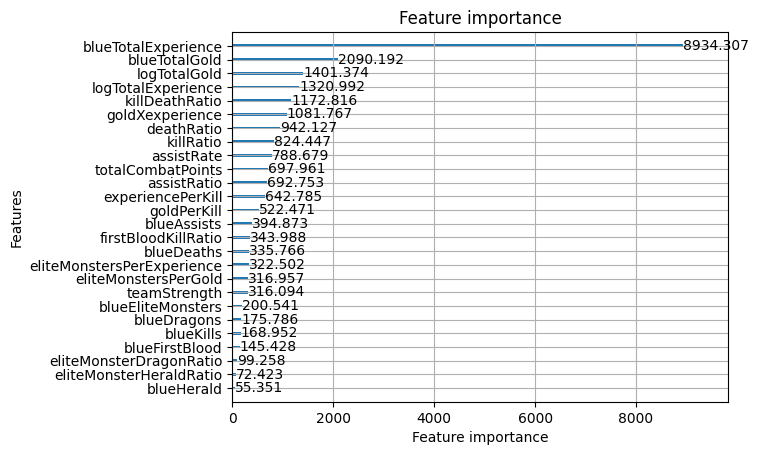

deathRatio: 406
assistRate: 402
killDeathRatio: 398
killRatio: 393
totalCombatPoints: 343
assistRatio: 337
experiencePerKill: 233
goldPerKill: 200
blueAssists: 191
teamStrength: 177
blueDeaths: 167
blueTotalGold: 162
goldXexperience: 149
blueTotalExperience: 137
firstBloodKillRatio: 108
blueKills: 95
logTotalGold: 84
eliteMonstersPerExperience: 84
eliteMonstersPerGold: 77
logTotalExperience: 56
blueFirstBlood: 49
blueEliteMonsters: 49
blueDragons: 48
blueHerald: 30
eliteMonsterDragonRatio: 30
eliteMonsterHeraldRatio: 25
[1 1 1 ... 1 1 0]


In [7]:


# データの準備
X = train.drop(['blueWins', 'gameId'], axis=1)
y = train['blueWins']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

test_drop_gameId = test.drop('gameId', axis=1)

# Optunaでのハイパーパラメータチューニング
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'binary_error',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)

    verbose_eval = 0
    verbose = lgb.log_evaluation(verbose_eval)

    # 早期停止の設定
    early_stopping = lgb.early_stopping(stopping_rounds=10, verbose=True)
    model = lgb.train(param, lgb_train, num_boost_round=1000, valid_sets=[lgb_val], callbacks=[early_stopping, verbose])
    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = (y_pred > 0.5).astype(int)
    accuracy = accuracy_score(y_val, y_pred)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# 最適なハイパーパラメータでモデルを再学習
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_error'
best_params['verbosity'] = -1

lgb_train = lgb.Dataset(X, y)
model = lgb.train(best_params, lgb_train, num_boost_round=study.best_trial.number)

# テストデータに対する予測
y_test_pred = model.predict(test_drop_gameId)
y_test_pred_int = (y_test_pred > 0.5).astype(int)

# 特徴量の重要度をプロット
# importance_typeは'split'または'gain'のいずれかに設定できます。
# 'split'は特徴量が分割に使用された回数に基づく重要度を表示します。
# 'gain'は特徴量がモデルのパフォーマンス向上にどれだけ貢献したかを表示します。
lgb.plot_importance(model, importance_type='gain', max_num_features=30)
plt.show()

# 特徴量の重要度を取得
importance = model.feature_importance(importance_type='split')
feature_names = model.feature_name()

# 特徴量とその重要度をペアにして表示
feature_importances = sorted(zip(feature_names, importance), key=lambda x: x[1], reverse=True)
for name, imp in feature_importances:
    print(f"{name}: {imp}")



# 予測結果の表示
print(y_test_pred_int)


- testにy_test_pred結合

In [8]:
output = '../data/output/submit_cv_oputuna_add_feature_drop_gameId.csv'

In [9]:
submit = pd.DataFrame({
    '0': test['gameId'],
    '1': y_test_pred_int
})

# カラムヘッダー消去して出力
# ヘッダーなしでCSVファイルとして保存
submit.to_csv(output, header=False, index=False)

- 出力csvチェック

In [10]:
check = pd.read_csv(output)

In [11]:
check

,9,1
0,15,1
1,18,1
2,23,0
3,31,0
4,32,1
...,...,...
1994,9971,0
1995,9980,0
1996,9983,1
1997,9996,1
